In [63]:
%pip install pandas matplotlib scipy seaborn xelatex

ERROR: Could not find a version that satisfies the requirement xelatex (from versions: none)
ERROR: No matching distribution found for xelatex
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from scipy.signal import savgol_filter
from dateutil import tz

In [3]:
from common import combine_csvs
from common import region_mapping
import common

In [23]:
N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'
N_LATENCY = 'Latency (ms)'

N_STARLINK = 'Starlink'
N_SHAW = 'Home'

#src_dirs = ['data/trad_ping_2022-04-14', 'data/starlink_ping_2022-04-14/']
#src_dirs = ['data/Home_network_data/Ping/2022-06-06_traditional_measures_ping/', 'data/starlink-data/Ping/2022-06-06_starlink_ping/']
src_dirs = [
    ('Home', 'data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/'), 
    ('Starlink', 'data/starlink-data/Ping/2022-06-03_starlink_measurements_ping/'),
    ('Home', 'data/Home_network_data/Ping/2022-06-06_traditional_measures_ping/'),
    ('Starlink', 'data/starlink-data/Ping/2022-06-06_starlink_ping/'),
]

#matplotlib.use("pgf")
plot_params = {
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
}
out_path = 'output/Ping'
filename = os.path.join(out_path, 'out_plot')

In [7]:
plot_params['figure.figsize'] = (7.16, 4)
plot_params['figure.dpi'] = 300
matplotlib.rcParams.update()
sns_params = common.sns_params
sns_params['figure.figsize'] = (7.16, 4)
sns_params['figure.dpi'] = 300
sns.set_context("paper", rc=sns_params)

In [29]:
df = pd.DataFrame()
for type_name, folder in src_dirs:
    for region in os.scandir(folder):
        pattern = f"{region.path}/*"
        #print(pattern)
        df_temp = combine_csvs(glob.glob(pattern, recursive=True), None, header=None)
        df_temp = df_temp.iloc[:,[2, 3]]
        df_temp.rename(columns={df_temp.columns[0]: N_LATENCY, df_temp.columns[1]: N_TIMESTAMP}, inplace=True)
        df_temp[N_TIMESTAMP] = pd.to_datetime(df_temp[N_TIMESTAMP], unit='s')
        df_temp.sort_values(N_TIMESTAMP, inplace=True)
        df_temp[N_REGIONS] = region_mapping[region.name]
        df_temp[N_TYPE] = type_name

        if not df.empty:
            #df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
            #df = df.update(df_temp, errors='raise')
            df = pd.concat([df, df_temp])
        else:
            df = df_temp

df = df.reset_index(drop=True)
df

,Latency (ms),Timestamp,Regions,Type
0,190.0,2022-06-04 03:52:17,Sao Paulo,Home
1,189.0,2022-06-04 03:52:19,Sao Paulo,Home
2,191.0,2022-06-04 03:52:20,Sao Paulo,Home
3,189.0,2022-06-04 03:52:21,Sao Paulo,Home
4,195.0,2022-06-04 03:52:22,Sao Paulo,Home
...,...,...,...,...
19187681,279.0,2022-06-17 08:37:53,Mumbai,Starlink
19187682,272.0,2022-06-17 08:37:54,Mumbai,Starlink
19187683,275.0,2022-06-17 08:37:55,Mumbai,Starlink
19187684,271.0,2022-06-17 08:37:56,Mumbai,Starlink


In [31]:
#df.to_csv(os.path.join(out_path, '2022-06-17_end_all_ping_data.csv'), index=False)

In [6]:
#df_temp = combine_csvs(glob.glob(f'{src_dirs[1]}/US_West_N_California/*', recursive=True), 3, header=None)
#df_temp.index = pd.to_datetime(df_temp.index, unit='s')
#df_temp.sort_index()
#df.loc['2022-06-17 01']

In [9]:
# https://stackoverflow.com/questions/69300483/how-to-use-markers-with-ecdf-plot
def ecdf(data, array: bool=True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y

In [26]:
# Remove outliers
df_no_outliers = df[(np.abs(stats.zscore(df[N_LATENCY], nan_policy='omit')) < 3)]
df_no_outliers

,Latency (ms),Timestamp,Regions
0,190.0,2022-06-04 03:52:17,Sao Paulo
1,189.0,2022-06-04 03:52:19,Sao Paulo
2,191.0,2022-06-04 03:52:20,Sao Paulo
3,189.0,2022-06-04 03:52:21,Sao Paulo
4,195.0,2022-06-04 03:52:22,Sao Paulo
...,...,...,...
19187681,279.0,2022-06-17 08:37:53,Mumbai
19187682,272.0,2022-06-17 08:37:54,Mumbai
19187683,275.0,2022-06-17 08:37:55,Mumbai
19187684,271.0,2022-06-17 08:37:56,Mumbai


In [11]:
# Filter
df_processed = df_no_outliers
#df_processed = df.loc['2022-05-13 07:13:50':'2022-05-13 7:14:18']
#df_processed = df.loc['2022-06-05':'2022-06-05 01']

df_processed = df_processed.resample('12H').mean()
#df_processed.to_csv('output/out.csv')
df_processed

Home                                      \
                      Sao Paulo   Singapore      Sydney   Cape Town   
3                                                                     
2022-06-03 00:00:00         NaN         NaN         NaN         NaN   
2022-06-03 12:00:00         NaN         NaN         NaN         NaN   
2022-06-04 00:00:00  190.376186  198.642806  151.579307  293.394666   
2022-06-04 12:00:00  189.709078  198.626909  151.300116  289.875026   
2022-06-05 00:00:00  190.430158  198.586370  151.375099  291.075818   
2022-06-05 12:00:00  190.397847  198.947214  151.416355  290.592253   
2022-06-06 00:00:00  191.468697  197.446718  152.459162  293.659888   
2022-06-06 12:00:00  190.568493  194.239406  151.568161  292.541942   
2022-06-07 00:00:00  190.259658  193.463566  151.510481  292.352282   
2022-06-07 12:00:00  190.429726  195.605541  151.735731  292.454520   
2022-06-08 00:00:00  190.657238  196.831601  151.868809  289.667694   
2022-06-08 12:00:00  189.888145  194.075951  151.630070  288.451329   
2022-06-09 00:00:00         NaN         NaN         NaN         NaN   
2022-06-09 12:00:00  190.586289  193.826415  151.850132  293.810646   
2022-06-10 00:00:00  190.519418  193.583322  151.753586  288.931885   
2022-06-10 12:00:00  190.505948  193.757317  151.607133  290.832391   
2022-06-11 00:00:00  190.747640  193.816277  152.023635  289.009612   
2022-06-11 12:00:00  190.547717  193.586877  151.867143  289.651991   
2022-06-12 00:00:00  190.600445  193.794094  151.760857  288.765361   
2022-06-12 12:00:00  190.486765  193.591430  151.975937  288.877879   
2022-06-13 00:00:00  190.412203  194.056575  151.829097  288.897113   
2022-06-13 12:00:00  190.478334  195.028003  151.806883  289.059476   
2022-06-14 00:00:00  190.559375  195.595076  151.973303  292.131856   
2022-06-14 12:00:00  190.454666  198.404234  151.583142  292.817603   
2022-06-15 00:00:00  190.668608  198.992835  153.024427  300.164280   
2022-06-15 12:00:00  190.283277  199.169208  151.571127  319.077152   
2022-06-16 00:00:00  190.405599  198.766473  151.547113  322.814593   
2022-06-16 12:00:00  190.365330  198.874772  151.507624  307.656456   
2022-06-17 00:00:00  190.600723  198.470347  151.757193  289.596291   

                                                                       \
                    N. California     Bahrain       Tokyo      London   
3                                                                       
2022-06-03 00:00:00           NaN         NaN         NaN         NaN   
2022-06-03 12:00:00           NaN         NaN         NaN         NaN   
2022-06-04 00:00:00     33.694040  228.300094  142.469548  150.686510   
2022-06-04 12:00:00     33.993092  228.085410  142.466622  149.241315   
2022-06-05 00:00:00     34.115312  226.578218  142.488356  148.605130   
2022-06-05 12:00:00     34.378255  225.789494  142.371170  148.432405   
2022-06-06 00:00:00     34.808165  227.807249  143.264922  148.457947   
2022-06-06 12:00:00     33.834527  229.762557  142.891141  147.228430   
2022-06-07 00:00:00     33.401141  231.056487  141.522776  147.442072   
2022-06-07 12:00:00     33.768530  243.234520  141.880556  148.381326   
2022-06-08 00:00:00     33.840346  269.461617  142.011535  147.953277   
2022-06-08 12:00:00     34.148724  269.397229  141.888961  147.016421   
2022-06-09 00:00:00           NaN         NaN         NaN         NaN   
2022-06-09 12:00:00     34.644577  277.777465  141.990977  145.595126   
2022-06-10 00:00:00     33.920576  277.160383  142.275628  143.795853   
2022-06-10 12:00:00     33.871340  274.653742  142.762619  143.622200   
2022-06-11 00:00:00     34.352586  276.768662  142.974214  144.772016   
2022-06-11 12:00:00     33.883383  280.574855  142.620139  152.498980   
2022-06-12 00:00:00     33.826529  277.766357  142.562932  155.352486   
2022-06-12 12:00:00     33.888316  277.485540  142.450971  156.058769   
2022-06-13 00:00:00     33.853124  277.483184  142.275650  150.818845   
20

In [12]:
df_regs_interp = df_processed.interpolate(method='linear')
#df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,41,1))
df_regs_interp

Home                                      \
                      Sao Paulo   Singapore      Sydney   Cape Town   
3                                                                     
2022-06-03 00:00:00         NaN         NaN         NaN         NaN   
2022-06-03 12:00:00         NaN         NaN         NaN         NaN   
2022-06-04 00:00:00  190.376186  198.642806  151.579307  293.394666   
2022-06-04 12:00:00  189.709078  198.626909  151.300116  289.875026   
2022-06-05 00:00:00  190.430158  198.586370  151.375099  291.075818   
2022-06-05 12:00:00  190.397847  198.947214  151.416355  290.592253   
2022-06-06 00:00:00  191.468697  197.446718  152.459162  293.659888   
2022-06-06 12:00:00  190.568493  194.239406  151.568161  292.541942   
2022-06-07 00:00:00  190.259658  193.463566  151.510481  292.352282   
2022-06-07 12:00:00  190.429726  195.605541  151.735731  292.454520   
2022-06-08 00:00:00  190.657238  196.831601  151.868809  289.667694   
2022-06-08 12:00:00  189.888145  194.075951  151.630070  288.451329   
2022-06-09 00:00:00  190.237217  193.951183  151.740101  291.130987   
2022-06-09 12:00:00  190.586289  193.826415  151.850132  293.810646   
2022-06-10 00:00:00  190.519418  193.583322  151.753586  288.931885   
2022-06-10 12:00:00  190.505948  193.757317  151.607133  290.832391   
2022-06-11 00:00:00  190.747640  193.816277  152.023635  289.009612   
2022-06-11 12:00:00  190.547717  193.586877  151.867143  289.651991   
2022-06-12 00:00:00  190.600445  193.794094  151.760857  288.765361   
2022-06-12 12:00:00  190.486765  193.591430  151.975937  288.877879   
2022-06-13 00:00:00  190.412203  194.056575  151.829097  288.897113   
2022-06-13 12:00:00  190.478334  195.028003  151.806883  289.059476   
2022-06-14 00:00:00  190.559375  195.595076  151.973303  292.131856   
2022-06-14 12:00:00  190.454666  198.404234  151.583142  292.817603   
2022-06-15 00:00:00  190.668608  198.992835  153.024427  300.164280   
2022-06-15 12:00:00  190.283277  199.169208  151.571127  319.077152   
2022-06-16 00:00:00  190.405599  198.766473  151.547113  322.814593   
2022-06-16 12:00:00  190.365330  198.874772  151.507624  307.656456   
2022-06-17 00:00:00  190.600723  198.470347  151.757193  289.596291   

                                                                       \
                    N. California     Bahrain       Tokyo      London   
3                                                                       
2022-06-03 00:00:00           NaN         NaN         NaN         NaN   
2022-06-03 12:00:00           NaN         NaN         NaN         NaN   
2022-06-04 00:00:00     33.694040  228.300094  142.469548  150.686510   
2022-06-04 12:00:00     33.993092  228.085410  142.466622  149.241315   
2022-06-05 00:00:00     34.115312  226.578218  142.488356  148.605130   
2022-06-05 12:00:00     34.378255  225.789494  142.371170  148.432405   
2022-06-06 00:00:00     34.808165  227.807249  143.264922  148.457947   
2022-06-06 12:00:00     33.834527  229.762557  142.891141  147.228430   
2022-06-07 00:00:00     33.401141  231.056487  141.522776  147.442072   
2022-06-07 12:00:00     33.768530  243.234520  141.880556  148.381326   
2022-06-08 00:00:00     33.840346  269.461617  142.011535  147.953277   
2022-06-08 12:00:00     34.148724  269.397229  141.888961  147.016421   
2022-06-09 00:00:00     34.396651  273.587347  141.939969  146.305774   
2022-06-09 12:00:00     34.644577  277.777465  141.990977  145.595126   
2022-06-10 00:00:00     33.920576  277.160383  142.275628  143.795853   
2022-06-10 12:00:00     33.871340  274.653742  142.762619  143.622200   
2022-06-11 00:00:00     34.352586  276.768662  142.974214  144.772016   
2022-06-11 12:00:00     33.883383  280.574855  142.620139  152.498980   
2022-06-12 00:00:00     33.826529  277.766357  142.562932  155.352486   
2022-06-12 12:00:00     33.888316  277.485540  142.450971  156.058769   
2022-06-13 00:00:00     33.853124  277.483184  142.275650  150.818845   
20

In [35]:
df_cdf = df_unstacked.groupby([N_TYPE, N_REGIONS])['latency'].apply(ecdf, False)
df_cdf

x         y
Type     Regions                         
Home     Bahrain 0   225.789494  0.038462
                 1   226.578218  0.076923
                 2   227.807249  0.115385
                 3   228.085410  0.153846
                 4   228.300094  0.192308
...                         ...       ...
Starlink Tokyo   24  158.415054  0.862069
                 25  161.737027  0.896552
                 26  162.919596  0.931034
                 27  172.241848  0.965517
                 28  173.227308  1.000000

[485 rows x 2 columns]

In [ ]:
#df_pivot = df_unstacked.pivot_table(index=[N_REGIONS, 'timestamp'], columns='type', values='latency')
#print(df_pivot.head())

g = sns.catplot(data=df_unstacked, x='type', y='latency', col=N_REGIONS, col_wrap=4, kind='box', height=2,
        aspect=0.895, showfliers=True)
g.set(yscale='log')
g.tight_layout()
(g.set_axis_labels('Provider', 'Latency (ms)')
        .set_titles("{col_name}"))

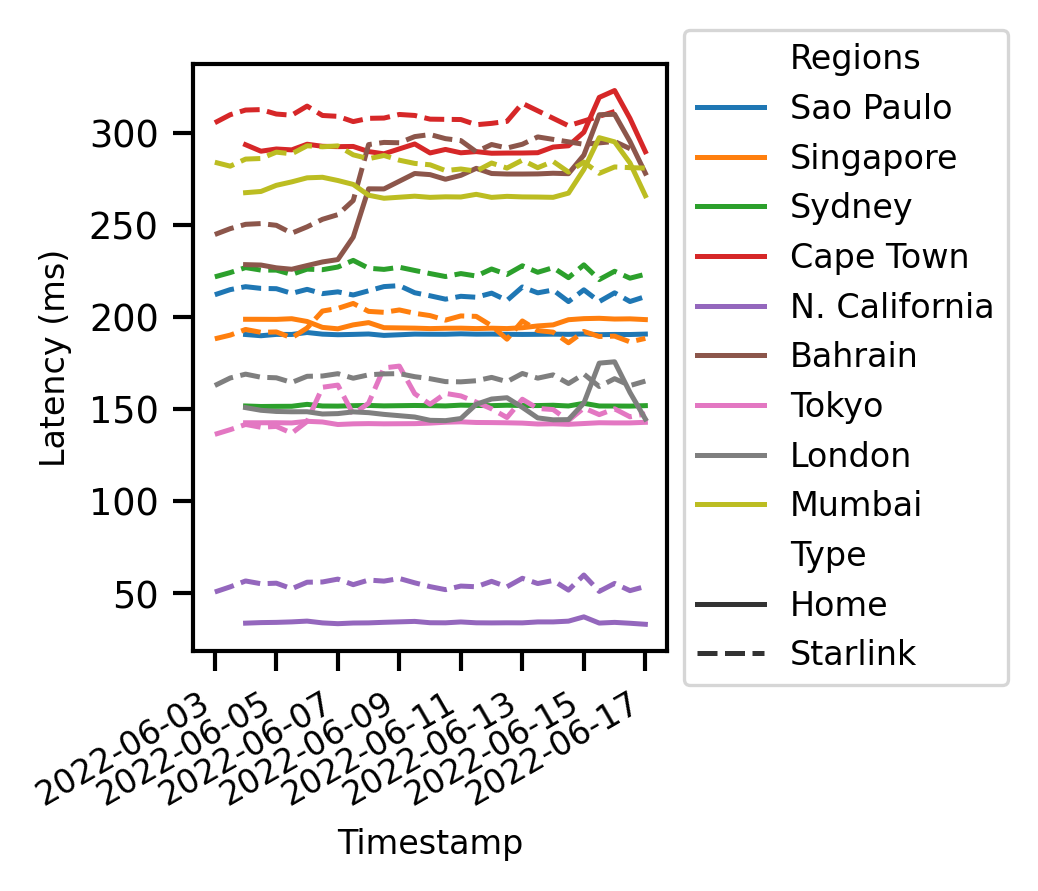

In [36]:
fig, ax = plt.subplots(figsize=(3.5,3), dpi=300)
#fig, ax = plt.subplots(figsize=(7.16,4), dpi=100)
#fig, ax = plt.subplots(figsize=(20,10))

g = sns.lineplot(data=df_unstacked, x=N_TIMESTAMP, y=N_LATENCY, hue=N_REGIONS, style=N_TYPE, ax=ax)
g.figure.autofmt_xdate()
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Latency (ms)')
g.figure.tight_layout()

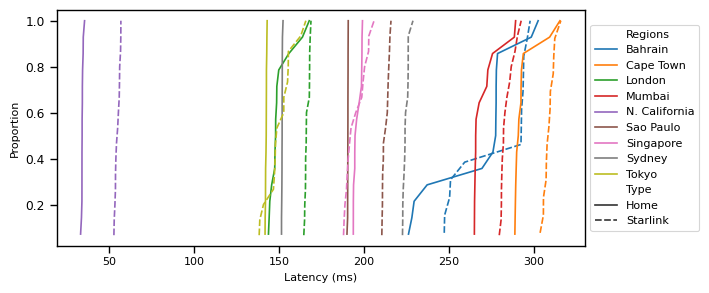

In [34]:
#fig, ax = plt.subplots(figsize=(3.5,2))
#fig, ax = plt.subplots(figsize=(7.16,2.5))
fig_cdf, ax_cdf = plt.subplots(figsize=(7.16,3), dpi=100)

#g = sns.ecdfplot(data=df_unstacked, x='latency', hue='Type Region', ax=ax)
g = sns.lineplot(data=df_cdf, x='x', y="y", hue=N_REGIONS, style=N_TYPE, ax=ax_cdf)
#g.set(xscale='log')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax_cdf.set_xlabel('Latency (ms)')
ax_cdf.set_ylabel('Proportion')
fig_cdf.tight_layout()

In [28]:
#_, ax_hist = plt.subplots(figsize=(7.16,4), dpi=300)

g_hist = sns.displot(
    data=df_no_outliers, 
    x=N_LATENCY, col=N_REGIONS, hue=N_TYPE, kind='ecdf', height=2, aspect=0.716, col_wrap=5)
g_hist.set_titles(col_template="{col_name}")
g_hist.tight_layout()


ValueError: Could not interpret value `Type` for parameter `hue`

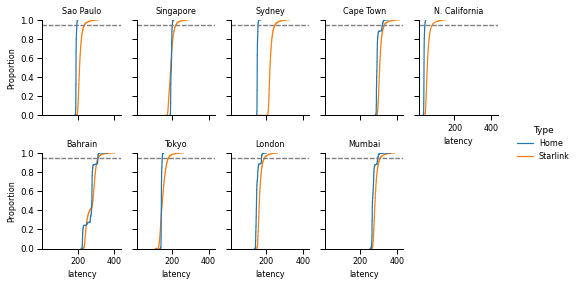

In [17]:
g_hist.refline(y=0.9)
g_hist.refline(y=0.95)
g_hist.refline(y=0.99)
g_hist.set_titles(col_template="{col_name}")
g_hist.tight_layout()

In [19]:
g_hist.savefig(f'{filename}_cdf.pgf', bbox_inches='tight')

In [47]:
nt_perc = df_unstacked.groupby([N_TYPE, N_REGIONS]).quantile(.90)
nf_perc = df_unstacked.groupby([N_TYPE, N_REGIONS]).quantile(.95)
nn_perc = df_unstacked.groupby([N_TYPE, N_REGIONS]).quantile(.99)

In [48]:
def diff_table(percentile):
    df_perc = percentile.reset_index().pivot(index=N_REGIONS, columns=N_TYPE, values='latency')
    df_perc['diff'] = df_perc['Starlink'] - df_perc['Home']
    return df_perc.reset_index().pivot_table(columns=N_REGIONS, values='diff')
    
df_perc = diff_table(nt_perc)
df_perc = pd.concat([df_perc, diff_table(nf_perc)])
df_perc = pd.concat([df_perc, diff_table(nn_perc)])
df_perc['Percentile'] = ['90%', '95%', '99%']
df_perc = df_perc.set_index('Percentile')
df_perc

Regions,Bahrain,Cape Town,London,Mumbai,N. California,Sao Paulo,Singapore,Sydney,Tokyo
Percentile,,,,,,,,,
90%,-4.0,6.0,8.0,8.0,32.4,35.0,13.0,85.0,28.0
95%,3.0,12.0,17.0,14.0,41.2,43.0,21.0,94.0,35.0
99%,28.0,39.0,47.0,43.0,71.7,75.0,49.0,126.0,64.0


In [56]:
file_path = os.path.join('output/Ping/', 'Percentiles.tex')
styler = df_perc.style
styler.format(precision=1)
styler.to_latex(file_path)

In [65]:
fig.savefig(f'{filename}.pgf', bbox_inches='tight')
fig_cdf.savefig(f'{filename}_cdf.pgf', bbox_inches='tight')
#fig.savefig(f'{filename}.pgf', bbox_inches='tight')

In [ ]:
########
#fig, axs = plt.subplots(1, num_regs, figsize=(7.16,5))
#ax_big = fig.add_subplot(111, frameon=False)

#df_regions = []
#for i in range(num_regs):
#    df_region = df.iloc[:,[i,(num_regs+i)]]
#    boxplt = sns.boxplot(x="variable", y="value", data=pd.melt(df_region), ax=axs[i], showfliers=False)

#    raw_region = df_region.columns[0]
#    region = raw_region.split('/')[1].replace('_',' ').strip()
#    boxplt.set(xlabel=region, ylabel=None)

#    #axs[i].set(yscale='log')
#    axs[i].set_xticklabels(labels=["Shaw", "Starlink"], fontsize=9)
#    axs[i].tick_params(labelsize=9)


#ax_big.set_xlabel("Network Provider and Region", fontsize=10, labelpad=30, fontweight='bold')
#ax_big.set_ylabel("Latency (ms)", fontsize=10, labelpad=30, fontweight='bold')
#ax_big.set_yticklabels([])
#ax_big.set_xticklabels([])
#ax_big.tick_params(
#    which='both',
#    bottom=False,
#    left=False,
#    right=False,
#    top=False)
#ax_big.grid(False)
#############